### Model Description 

* The model uses a payoff function of the form $$Ern  - cn^2$$, 
    - $E$ is Shannon Entropy within a cell. We use the following discretized form with agents divided into $g$ number of groups       based on their ability levels. $$E = -\sum_{i=1}^{i=g}p_i\log_ep_i, \text{where } p_i=\frac{\text{No. of occurences of agent of Type i in a cell}}{\text{No. of agents in the city/cell}}$$ 
    - $r$ is the ability of an agent where $r\in(0,1)$ and drawn from a uniform distribution.
    - The ability level domain is divided into $g$ equal intervals with size $\frac{1}{g}$ and agents are classified as $\text{Type }1$ if $r\in(0,\frac{1}{g})$, $\text{Type }2$ if $r\in(\frac{1}{g},\frac{2}{g})$ and so on. So for $g=4$, an agent with $r=0.66$ is a $\text{Type }3$ agent as $0.66\in(0.5,0.75)$. 
    - $n$ is the number of agents in the cell and $c$ is a constant.

    
* The model space is **20x20** size Multigrid allowing multiple agents to be present in a cell/city.

* Agents use bounded rationality. Each agent is initialized with attribute **radius** which defines the maximum number of cells it considers while making a move. The radius is defined in a way s.t higher ability agents are more mobile than lower ability agents. This is done by having the radius drawn from a scaled beta distribution $\beta(a,b)$ with shape parameters $a=r\text{ , }b=1-r$. So for higher $r$ the distribution is skewed to right meaning a greater chance of having larger values and vice-versa. The scaling factor is 10, which is half of our grid size. The distribution of radius is illustrated below.

* The model takes the total number of agents in all cities *'$N$'*, negative coefficient *'$c$'* and number of skill groups 
'$g$'* as inputs. The model also takes agent activation schedule as an input to test Random and Simulataneous activation of agents at each step. Pass **activation = 0** for Random Activation and **activation = 1** for Simultaneous Activation.


In [3]:
from model import City_Model
import SALib
import agent
from SALib.sample import saltelli
from SALib.analyze import sobol
import pandas as pd
import random
import numpy as np
import time
import math
import operator
from IPython.display import clear_output 
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import CanvasGrid, ChartModule, TextElement
from mesa.visualization.UserParam import UserSettableParameter
from mesa.batchrunner import BatchRunner
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.ticker as ticker
import scipy.stats as st
from scipy.stats import norm
from itertools import combinations
import statistics
from helpers import *
import matplotlib.pyplot as plt

### Decide here wether you want to include the 'Work From Home' ability for agent. 
Adding this will make that all agents are able to live in one city and work in another. Meaning they get the utility benefits from living in the city they work and pay the costs for the city they live in.

In [4]:
# Fill in Yes/No
agentsWorkFromHome = "No"
if agentsWorkFromHome == "No":
    agent_class = agent.Habitant
else:
    agent_class = agent.HabitantWFH

### Vision attribute of the agent for different skill levels($r$). Model radius 10

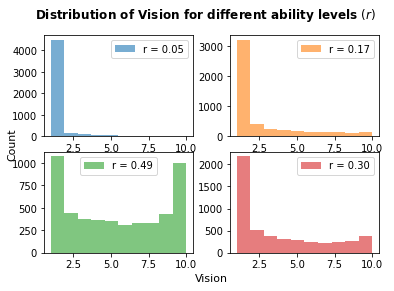

In [5]:
ability_list = [np.random.uniform() for x in range(4)]
vision_list = []
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for r in ability_list:
    temp_list = []
    for j in range(5000):
        temp_list.append(math.ceil(np.random.beta(r,(1-r)) * 10))
    vision_list.append(temp_list)
    
fig ,axs = plt.subplots(2,2) 
axs = axs.ravel()
for i ,r in enumerate(ability_list):
    axs[i].hist(vision_list[i],alpha=0.6,label='r = {:.2f}'.format(r), color=colors[i])
    axs[i].legend(loc='best')
    
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Vision",fontsize=11)
plt.ylabel("Count",fontsize=11)
plt.subplots_adjust(wspace=0.25, hspace=0.15)
fig.suptitle(r'Distribution of Vision for different ability levels $(r)$',fontweight='bold',fontsize=12)

plt.show() 

### Single run of the Model

In [6]:
N=1000
num_groups=5
neg_coff = 0.01
activation = 0
STEPS = 30
test_model = City_Model(N=N, num_groups=num_groups, activation=activation, neg_coff=neg_coff, agent_class=agent_class) 
for i in range(STEPS): # run model for some steps
    print(f"Step {i}")
    test_model.step()
    
city_evolution = test_model.datacollector.get_model_vars_dataframe()

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29


here
hereto
Agent type 0:
mean = 33.55 and variance = 18334.04
Agent type 1:
mean = 43.7 and variance = 44427.53
Agent type 2:
mean = 23.77 and variance = 32407.31
Agent type 3:
mean = 51.33 and variance = 116005.97
Agent type 4:
mean = 39.02 and variance = 84200.91
Agent type 5:
mean = 31.07 and variance = 9574.74
Agent type 6:
mean = 43.94 and variance = 33213.3
Agent type 7:
mean = 54.5 and variance = 75204.17
Agent type 8:
mean = 56.58 and variance = 106038.23
Agent type 9:
mean = 40.54 and variance = 87870.33
Agent type 10:
mean = 21.82 and variance = 5954.25


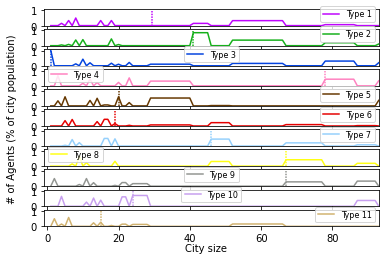

0.8832252795211949 -0.7129320013265451


In [7]:
# Collect data at last step 
plot_dict = city_evolution["Skill_dist"].iloc[STEPS-1]

# Plot the distribution of agents across different city sizes, per type of agent.
bar_plot(num_groups, a_dict= plot_dict)

# Statistics for Zipf's Law
slope, intercept, r_value, p_value, std_err = regress(city_evolution.iloc[i]["Ranks"])
print(r_value**2, slope)

### Visualize city sizes at each step

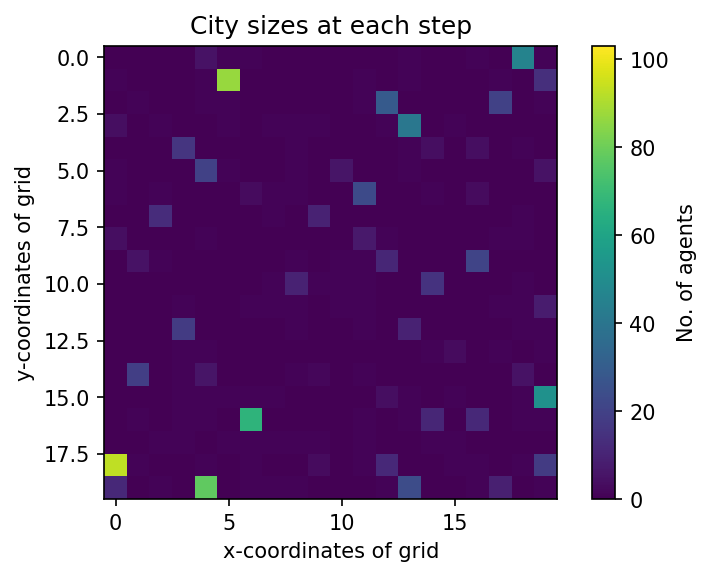

In [12]:
%matplotlib inline
## Plot city sizes over time. 
MIN = min(min(min(x.tolist()) for x in city_evolution["City_sizes"]))
MAX = max(max(max(x.tolist()) for x in city_evolution["City_sizes"]))

for i in range(STEPS):
    clear_output(wait=True)
    fig = plt.figure(dpi=150)
    plt.imshow(city_evolution["City_sizes"][i])
    plt.title("City sizes at each step")
    plt.xlabel("x-coordinates of grid")
    plt.ylabel("y-coordinates of grid")
    plt.colorbar(label="No. of agents")
    plt.clim(MIN, MAX)
    plt.show()
    time.sleep(0.1)

### The block below creates a animation of the visual; city sizes at each step

In [ ]:
'''
Create animation and save
'''
%matplotlib notebook

MIN = min(min(min(x.tolist()) for x in city_evolution["City_sizes"]))
MAX = max(max(max(x.tolist()) for x in city_evolution["City_sizes"]))

fig = plt.figure(dpi=400)
ax = plt.axes()

a=city_evolution["City_sizes"]
im=plt.imshow(a[0])


# animation function.  
def animate(i):

    im.set_array(a[i])
    im.set_clim(MIN, MAX)
    return [im]

plt.title("City sizes at each step")
plt.xlabel("x-coordinates of grid")
plt.ylabel("y-coordinates of grid")
plt.colorbar(label="No. of agents")
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))


anim = animation.FuncAnimation(fig, animate, frames=STEPS, interval=500,blit=True)

#Save the animation
'''
f = r"C:\...Set a PATH....\citysize-vid.mp4" 
writervideo = animation.FFMpegWriter(fps=1) 
anim.save(f, writer=writervideo)'''

### Plot overall model utitlites at each step

<AxesSubplot:title={'center':'Model Utilities at each step'}, xlabel='steps', ylabel='utility'>

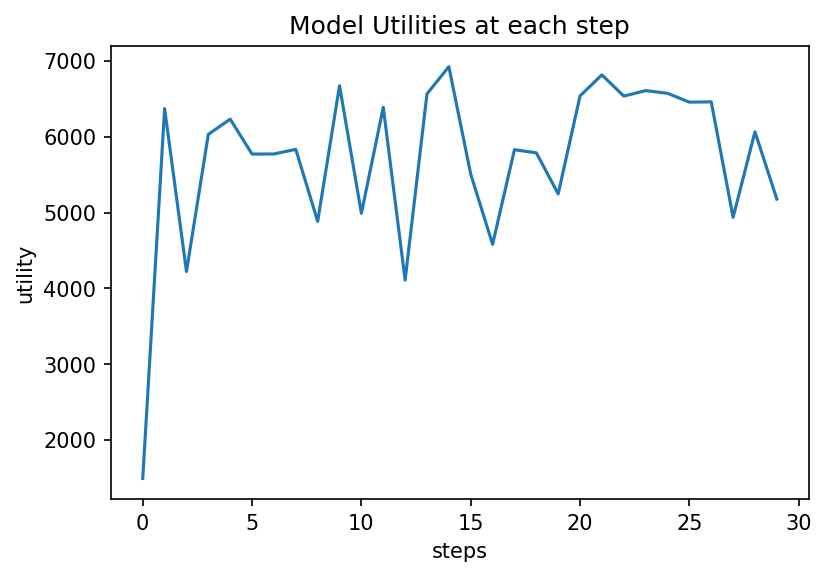

In [9]:
fig = plt.figure(dpi=150)
city_evolution["Utility"].plot(xlabel="steps", ylabel="utility",title="Model Utilities at each step")

### Visualize city rank - size distribution of cities(cells) at each step

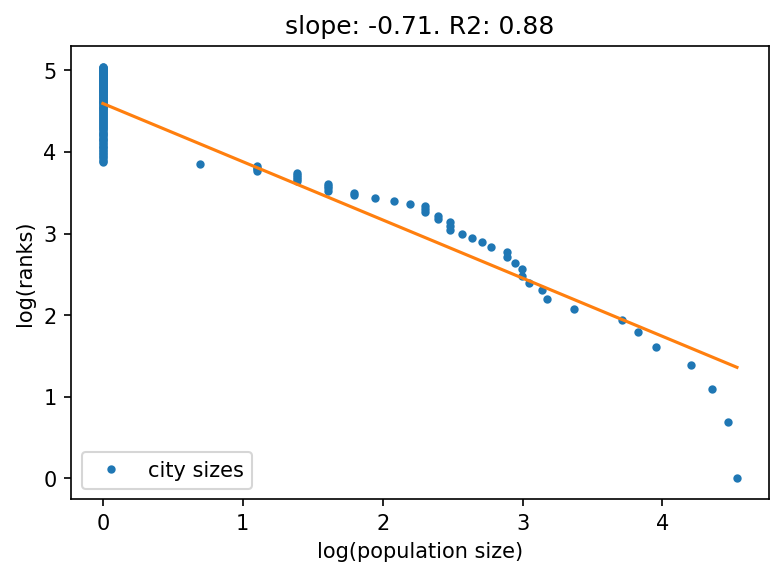

-0.7129320013265451 0.8832252795211949


In [10]:
for i in range(STEPS):
    ranklist = city_evolution.iloc[i]["Ranks"]
    clear_output(wait=True)
    n = len(ranklist)
    ranks = range(1, n+1)                        # y-axis: log(the ranks)
    pops = [pops for (coords, pops) in ranklist] # x-axis: log(the poplution size)
    ## Remove 0's to avoid log(0)
    if 0 in pops:
        idx = pops.index(0)
        pops = pops[:idx]
        ranks = ranks[:idx]
    else:
        idx = len(pops)-1
        pops = pops[:idx]
        ranks = ranks[:idx]
    ## regression interval
    x = np.linspace(np.log(pops[idx-1]),np.log(pops[0]),3)
    ## regression
    slope, intercept, r_value, p_value, std_err = st.linregress(np.log(np.array(pops)), np.log(np.array(ranks)))
    ## 'scatter' plot and regression line
    fig = plt.figure(dpi=150)
    plt.plot(np.log(pops), np.log(ranks), '.',label='city sizes')
    plt.plot(x,slope*x+intercept)
    ## plot specifics
    plt.title('slope: {}. R2: {}'.format(round(slope,2),round(r_value**2,2)))
    plt.xlabel('log(population size)')
    plt.ylabel('log(ranks)')
    plt.legend(loc='lower left')
    plt.show()
    
    time.sleep(0.1)
    
print(slope,r_value**2)

### See entropy distribution of cities at the end of each Model run. 

**Visualise entropy distribution at each step**

In [ ]:
for i in range(5):                       # iterate the model 5 times
    model = city_model()                 # default params used
    for j in range(STEPS):                  # run each model for some steps
        model.step()
    city_evolution = model.datacollector.get_model_vars_dataframe()    
    eList = []
    for j in city_evolution.iloc[STEPS-1]["Entropy"]:   # check the entropies at end of model run
        eList.append(j[1])   
    intv95 = st.norm.interval(alpha=0.95, loc=np.mean(eList), scale=st.sem(eList))
    # Plot the histogram.
    fig = plt.figure(dpi=150)
    plt.hist(eList, bins= "auto", density=True,color='firebrick',alpha=0.6, 
             label="Distribution of entropies at end of model run {}".format(i+1))
    plt.axvline(x=np.mean(eList), color='k', linestyle='dashdot', label="Mean")
    plt.axvline(x=intv95[0],color='yellow',linestyle='--',linewidth=0.8,label='Lower bound of 95% Confidence Interval')
    plt.axvline(x=intv95[1],color='blue',linestyle='--',linewidth=0.8,label='Upper bound of 95% Confidence Interval')
    plt.xlabel('Entropy of cities')
    plt.ylabel('Frequency of occurence')
    plt.title("Distribution of cell entropies at the end of each Model iteration",pad=20)
    plt.legend(loc='best', shadow=True, prop={'size': 7}, facecolor="silver")
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

### Parameter sweep for $num\text{_}groups$ in $[3,4,5,6,7,8,9,10]$ using 10 model iterations and 20 steps for each model run. Random Activation

In [ ]:
fixed_params = {"N": 1000,"width": 20,
               "height": 20, "neg_coff": 10**-3, "activation": 0}
variable_params = {"num_groups": [3, 4, 5, 6, 7, 8, 9, 10]}

mod_iter = 10
mod_steps = 20
batch_run1 = BatchRunner(City_Model,
                        variable_params,
                        fixed_params,
                        iterations = mod_iter,
                        max_steps = mod_steps,
                        model_reporters={"Entropy": model_entropy, "Ranks": city_ranks, "Sizes": city_sizes, 
                                         "Skill-levels":skill_levels, "Utility": model_utility})
batch_run1.run_all()

In [ ]:
run_data = batch_run1.get_model_vars_dataframe()
run_data

### $R^2$ value tests

In [ ]:
   
r_dict = {"g3":[],"g4":[],"g5":[],"g6":[],"g7":[], "g8":[],"g9":[],"g10":[]}

for i in range(len(variable_params["num_groups"])*mod_iter):
    if int(i/10) == 0:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        r_dict["g3"].append(r_value**2)
    elif int(i/10) == 1:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        r_dict["g4"].append(r_value**2)
    elif int(i/10) == 2:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        r_dict["g5"].append(r_value**2)   
    elif int(i/10) == 3:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        r_dict["g6"].append(r_value**2)
    elif int(i/10) == 4:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        r_dict["g7"].append(r_value**2)
    elif int(i/10) == 5:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        r_dict["g8"].append(r_value**2)
    elif int(i/10) == 6:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        r_dict["g9"].append(r_value**2)
    elif int(i/10) == 7:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        r_dict["g10"].append(r_value**2)
    

fig, ax = plt.subplots(dpi=200)
ax.violinplot([r_dict["g3"],r_dict["g4"],r_dict["g5"],r_dict["g6"],r_dict["g7"],r_dict["g8"],
              r_dict["g9"],r_dict["g10"]],showmeans=True)
ax.get_xaxis().set_tick_params(direction='out')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(np.arange(1, 9))
ax.set_xticklabels(['G3','G4','G5','G6','G7','G8','G9','G10'])
ax.set_xlim(0.25, 8.75)
ax.set_xlabel(r'Different group sizes, $g$',fontsize=10)
ax.set_ylabel(r'$R^2 values$',fontsize=10)
ax.grid()


r_dict["g3"] = [np.mean(r_dict["g3"]), np.var(r_dict["g3"])]   
r_dict["g4"] = [np.mean(r_dict["g4"]), np.var(r_dict["g4"])]  
r_dict["g5"] = [np.mean(r_dict["g5"]), np.var(r_dict["g5"])]  
r_dict["g6"] = [np.mean(r_dict["g6"]), np.var(r_dict["g6"])]  
r_dict["g7"] = [np.mean(r_dict["g7"]), np.var(r_dict["g7"])]
r_dict["g8"] = [np.mean(r_dict["g8"]), np.var(r_dict["g8"])]
r_dict["g9"] = [np.mean(r_dict["g9"]), np.var(r_dict["g9"])]
r_dict["g10"] = [np.mean(r_dict["g10"]), np.var(r_dict["g10"])]
print(r"mean of $r^2$ values and variances", r_dict)

### $\beta$ value tests

In [ ]:
beta_dict = {"g3":[],"g4":[],"g5":[],"g6":[],"g7":[], "g8":[],"g9":[],"g10":[]}

for i in range(len(variable_params["num_groups"])*mod_iter):
    if int(i/10) == 0:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        beta_dict["g3"].append(slope)
    elif int(i/10) == 1:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        beta_dict["g4"].append(slope)
    elif int(i/10) == 2:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        beta_dict["g5"].append(slope)   
    elif int(i/10) == 3:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        beta_dict["g6"].append(slope)
    elif int(i/10) == 4:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        beta_dict["g7"].append(slope)
    elif int(i/10) == 5:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        beta_dict["g8"].append(slope)
    elif int(i/10) == 6:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        beta_dict["g9"].append(slope)
    elif int(i/10) == 7:
        slope, intercept, r_value, p_value, std_err = regress(run_data.iloc[i]["Ranks"])
        beta_dict["g10"].append(slope)

fig, ax = plt.subplots(dpi=200)
ax.violinplot([beta_dict["g3"],beta_dict["g4"],beta_dict["g5"],beta_dict["g6"],beta_dict["g7"],beta_dict["g8"],
              beta_dict["g9"],beta_dict["g10"]],showmeans=True)
ax.get_xaxis().set_tick_params(direction='out')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(np.arange(1, 9))
ax.set_xticklabels(['G3','G4','G5','G6','G7','G8','G9','G10'])
ax.set_xlim(0.25, 8.75)
ax.set_xlabel(r'Different group sizes, $g$',fontsize=10)
ax.set_ylabel(r'$\beta$ values',fontsize=10)
ax.grid()


beta_dict["g3"] = [np.mean(r_dict["g3"]), np.var(r_dict["g3"])]   
beta_dict["g4"] = [np.mean(r_dict["g4"]), np.var(r_dict["g4"])]  
beta_dict["g5"] = [np.mean(r_dict["g5"]), np.var(r_dict["g5"])]  
beta_dict["g6"] = [np.mean(r_dict["g6"]), np.var(r_dict["g6"])]  
beta_dict["g7"] = [np.mean(r_dict["g7"]), np.var(r_dict["g7"])]
beta_dict["g8"] = [np.mean(r_dict["g8"]), np.var(r_dict["g8"])]
beta_dict["g9"] = [np.mean(r_dict["g9"]), np.var(r_dict["g9"])]
beta_dict["g10"] = [np.mean(r_dict["g10"]), np.var(r_dict["g10"])]

print("mean slopes and variances", beta_dict)